In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import xgboost as xgb
from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# --- Загрузка и подготовка данных ---

def load_california():
    data = fetch_california_housing()
    X, y = data.data, data.target
    feature_names = data.feature_names
    return X, y, feature_names

def load_diabetes_data():
    data = load_diabetes()
    return data.data, data.target, data.feature_names

def load_ames():
    from openml import datasets
    ames = datasets.get_dataset(42165)
    X, y, _, _ = ames.get_data(target=ames.default_target_attribute, dataset_format='dataframe')
    X.fillna(X.median(), inplace=True)
    X = pd.get_dummies(X, drop_first=True)
    return X.values, y.values, list(X.columns)

# --- Предобработка ---

def preprocess(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# --- Модели ---

models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_seed=42)
}

# --- Монте-Карло бутстрэп для классических моделей ---

def monte_carlo_bootstrap(model, X_train, y_train, X_test, n_iter=50):
    preds = np.zeros((n_iter, len(X_test)))
    for i in range(n_iter):
        idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
        model.fit(X_train[idx], y_train[idx])
        preds[i] = model.predict(X_test)
    return preds

# --- Нейросеть с MC Dropout ---

class MLP_MC_Dropout(nn.Module):
    def __init__(self, input_dim, dropout_p=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def train_nn(model, train_loader, epochs=50, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds.squeeze(), yb)
            loss.backward()
            optimizer.step()

def mc_dropout_predict(model, X_test, n_iter=50):
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_iter):
            preds.append(model(X_test).cpu().numpy())
    preds = np.array(preds).squeeze()
    return preds.mean(axis=0), preds.std(axis=0)

# --- Метрики и визуализация ---

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, r2, mae

def plot_predictions(y_true, preds_mean, preds_std, title):
    x_axis = np.arange(len(y_true))
    plt.figure(figsize=(15,6))
    plt.plot(x_axis, y_true, label='Истинные значения', color='black')
    plt.plot(x_axis, preds_mean, label='Средние предсказания')
    plt.fill_between(x_axis, preds_mean - 1.96*preds_std, preds_mean + 1.96*preds_std,
                     alpha=0.3, label='95% доверительный интервал')
    plt.title(title)
    plt.legend()
    plt.show()



--- Эксперимент на California Housing ---
Обучаем и оцениваем Ridge...
  Без МК: MSE=0.5559, R2=0.5758, MAE=0.5332
  С МК бутстрэп: MSE=0.5533, R2=0.5778, MAE=0.5320


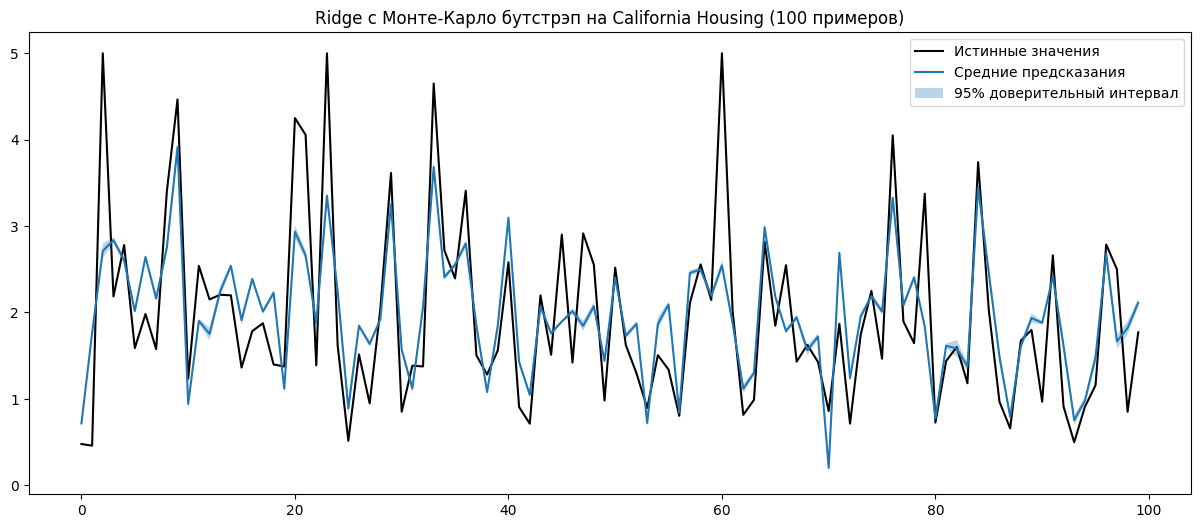

Обучаем и оцениваем Lasso...
  Без МК: MSE=0.6796, R2=0.4814, MAE=0.6222
  С МК бутстрэп: MSE=0.6793, R2=0.4816, MAE=0.6223


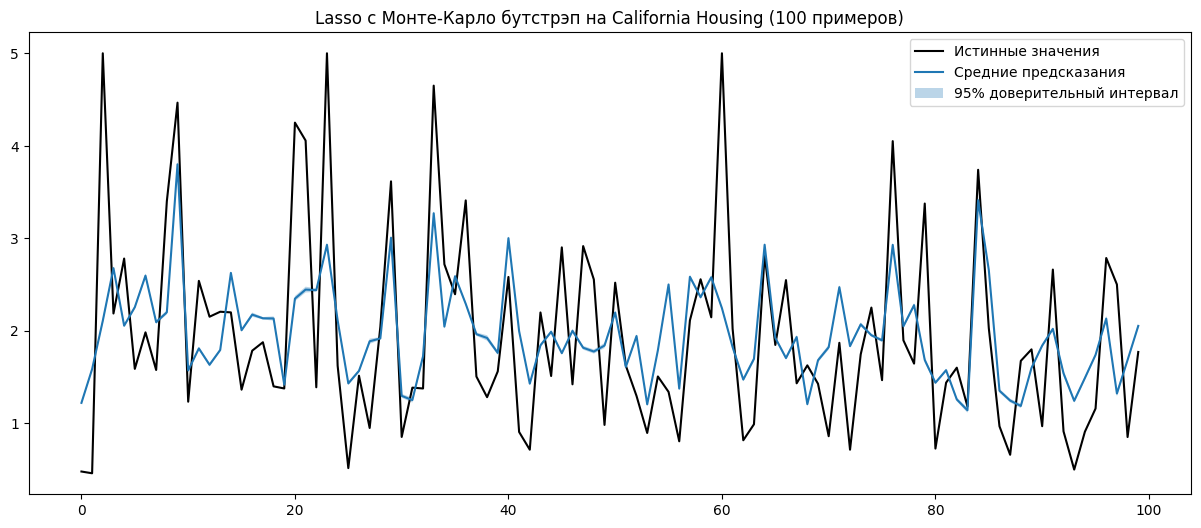

Обучаем и оцениваем ElasticNet...
  Без МК: MSE=0.6359, R2=0.5148, MAE=0.5970
  С МК бутстрэп: MSE=0.6356, R2=0.5150, MAE=0.5970


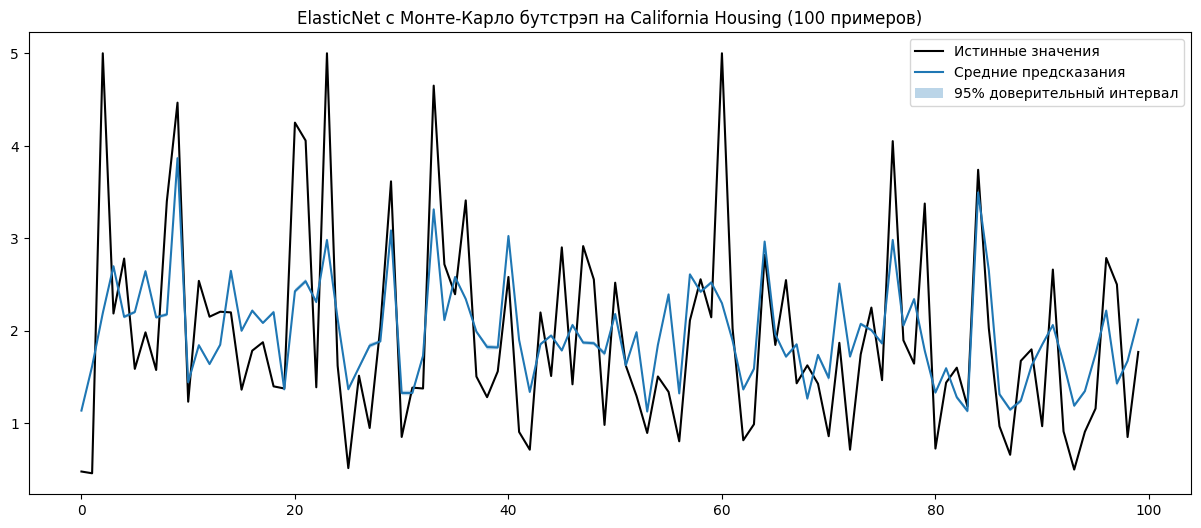

Обучаем и оцениваем XGBoost...
  Без МК: MSE=0.2952, R2=0.7747, MAE=0.3710
  С МК бутстрэп: MSE=0.2895, R2=0.7791, MAE=0.3667


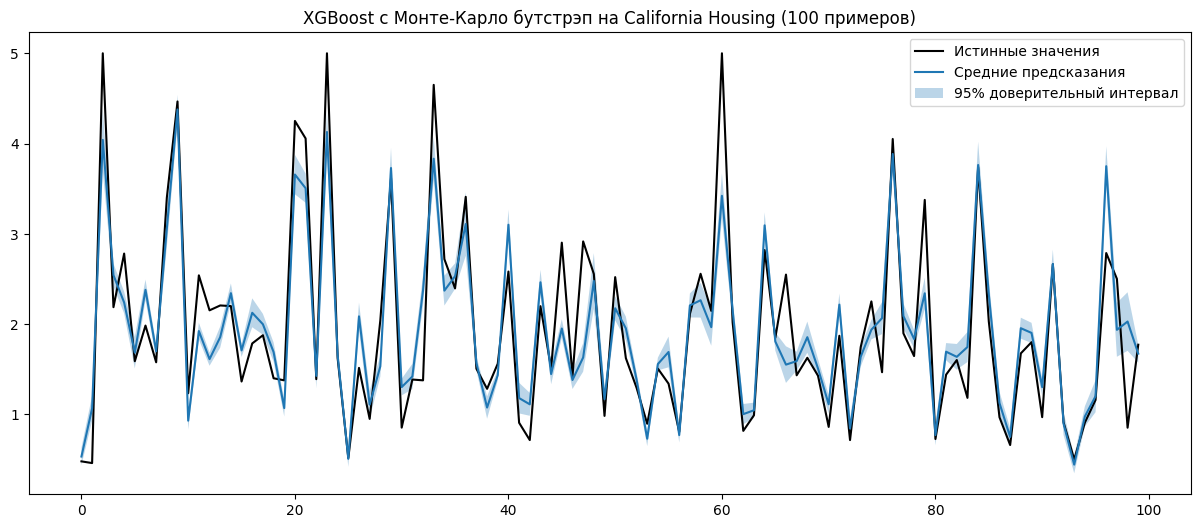

Обучаем и оцениваем CatBoost...
  Без МК: MSE=0.2995, R2=0.7714, MAE=0.3753
  С МК бутстрэп: MSE=0.2985, R2=0.7722, MAE=0.3737


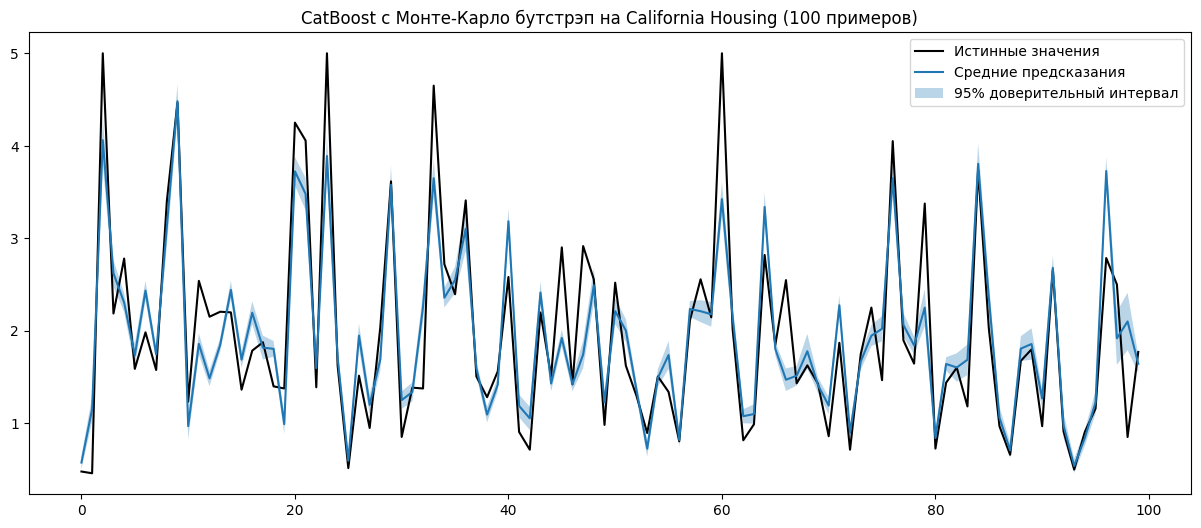


Обучаем MLP с MC Dropout...
MLP MC Dropout: MSE=0.2710, R2=0.7932, MAE=0.3489


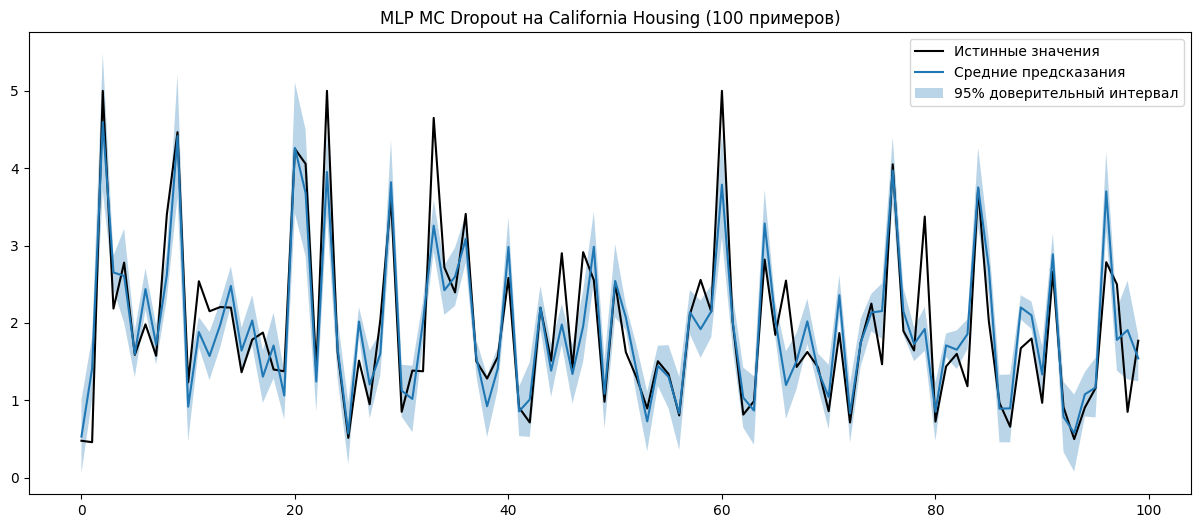


--- Эксперимент на Diabetes ---
Обучаем и оцениваем Ridge...
  Без МК: MSE=2892.0146, R2=0.4541, MAE=42.8120
  С МК бутстрэп: MSE=2912.2800, R2=0.4503, MAE=42.9684


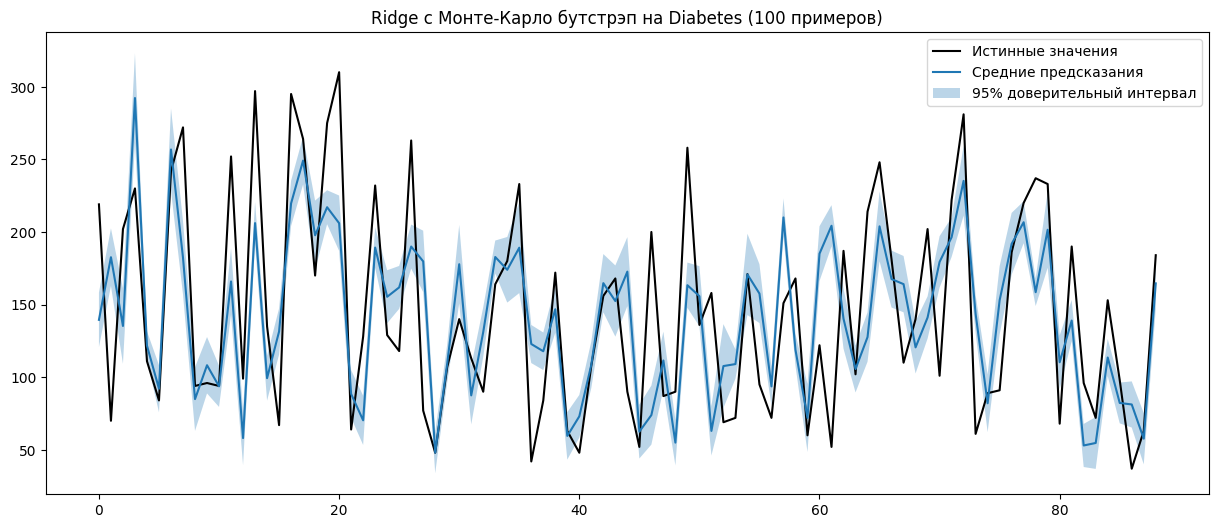

Обучаем и оцениваем Lasso...
  Без МК: MSE=2884.6243, R2=0.4555, MAE=42.8052
  С МК бутстрэп: MSE=2932.4336, R2=0.4465, MAE=42.8703


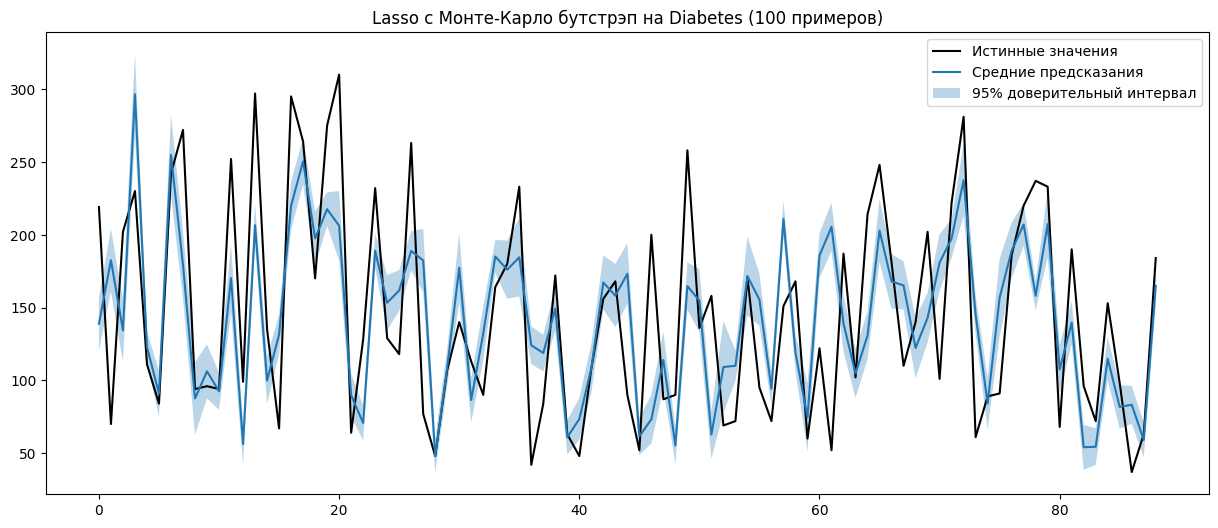

Обучаем и оцениваем ElasticNet...
  Без МК: MSE=2866.4613, R2=0.4590, MAE=42.8733
  С МК бутстрэп: MSE=2869.6359, R2=0.4584, MAE=42.9822


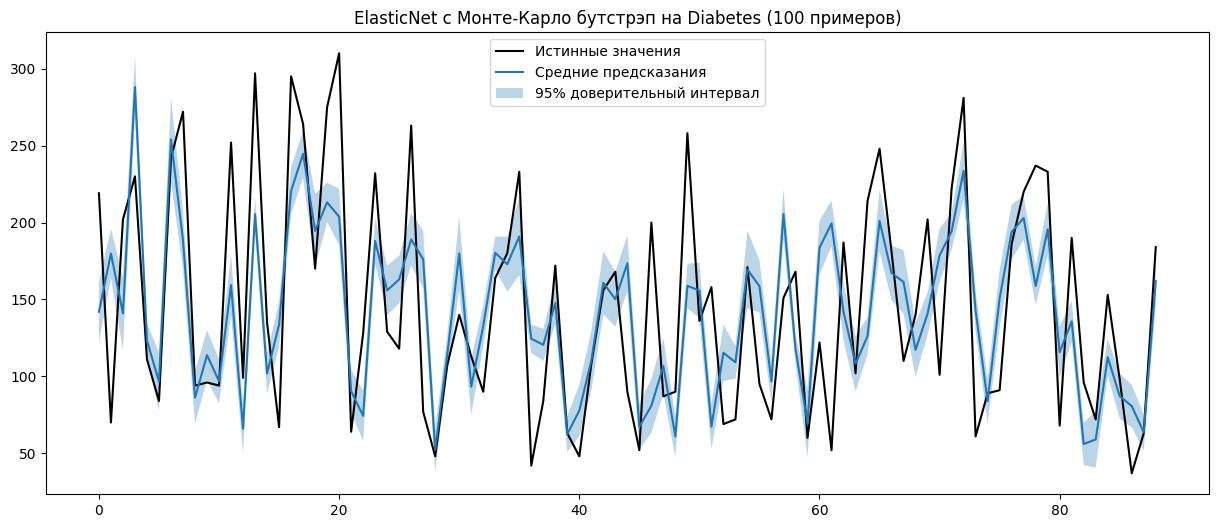

Обучаем и оцениваем XGBoost...
  Без МК: MSE=2959.4558, R2=0.4414, MAE=44.1140
  С МК бутстрэп: MSE=2767.8037, R2=0.4776, MAE=42.6106


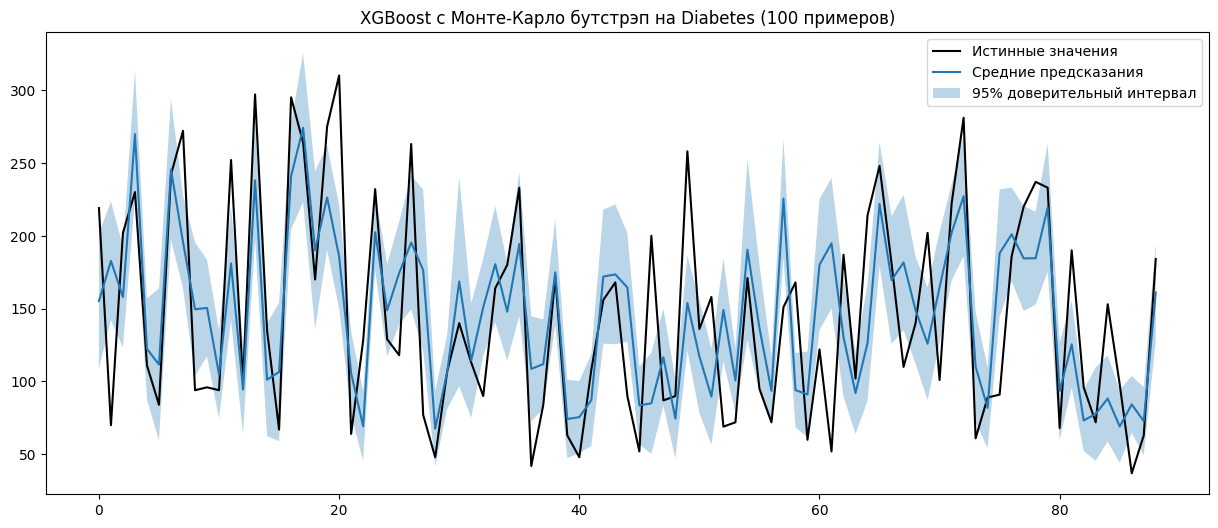

Обучаем и оцениваем CatBoost...
  Без МК: MSE=2661.5802, R2=0.4976, MAE=41.9200
  С МК бутстрэп: MSE=2650.4946, R2=0.4997, MAE=41.6726


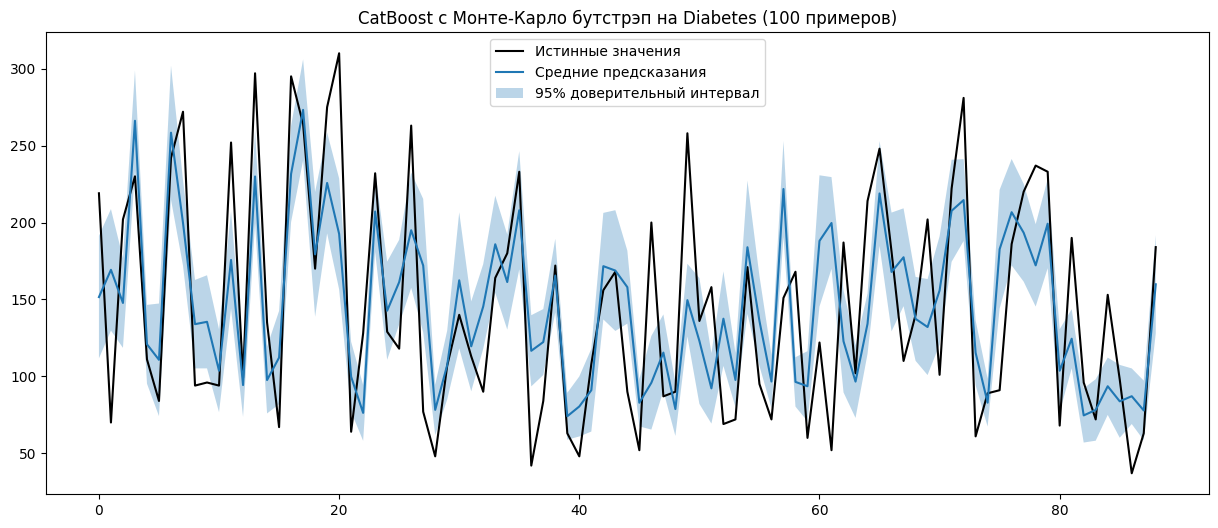


--- Эксперимент на Ames Housing ---
Обучаем и оцениваем Ridge...
  Без МК: MSE=1323203244.0567, R2=0.8275, MAE=19653.5350
  С МК бутстрэп: MSE=1016075814.2593, R2=0.8675, MAE=18685.1966


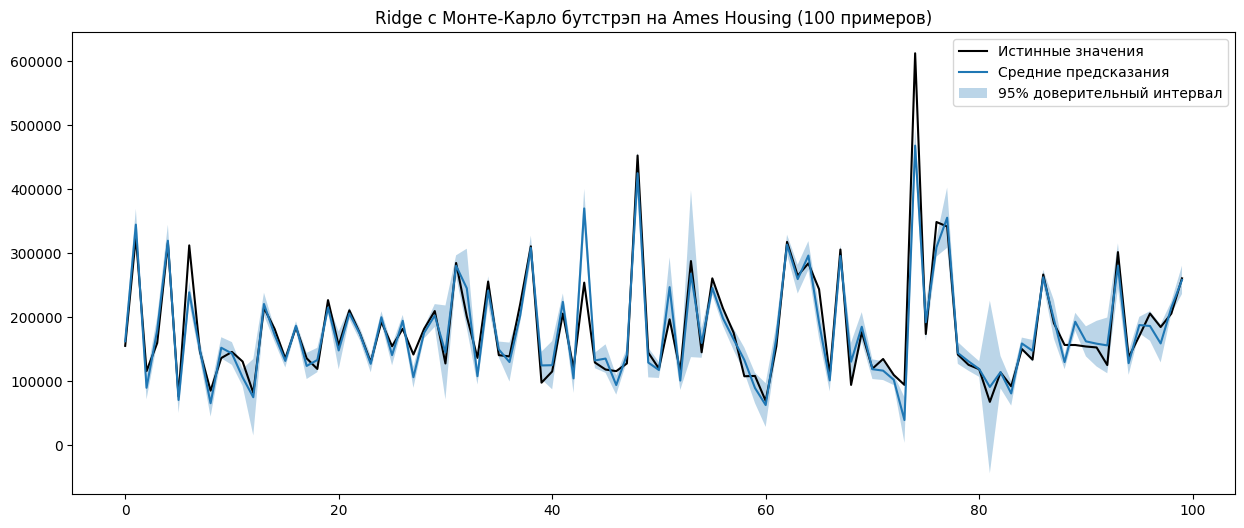

Обучаем и оцениваем Lasso...
  Без МК: MSE=1323518314.2284, R2=0.8274, MAE=19745.1061
  С МК бутстрэп: MSE=1119915461.8684, R2=0.8540, MAE=19034.4580


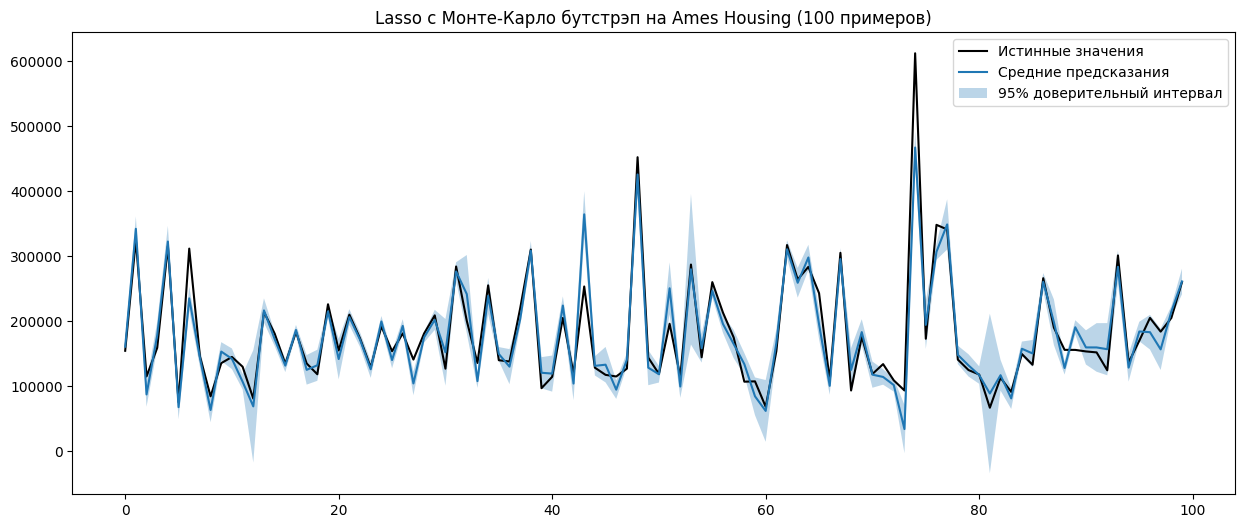

Обучаем и оцениваем ElasticNet...
  Без МК: MSE=1064945853.9147, R2=0.8612, MAE=19897.0864
  С МК бутстрэп: MSE=957268260.8889, R2=0.8752, MAE=18855.2922


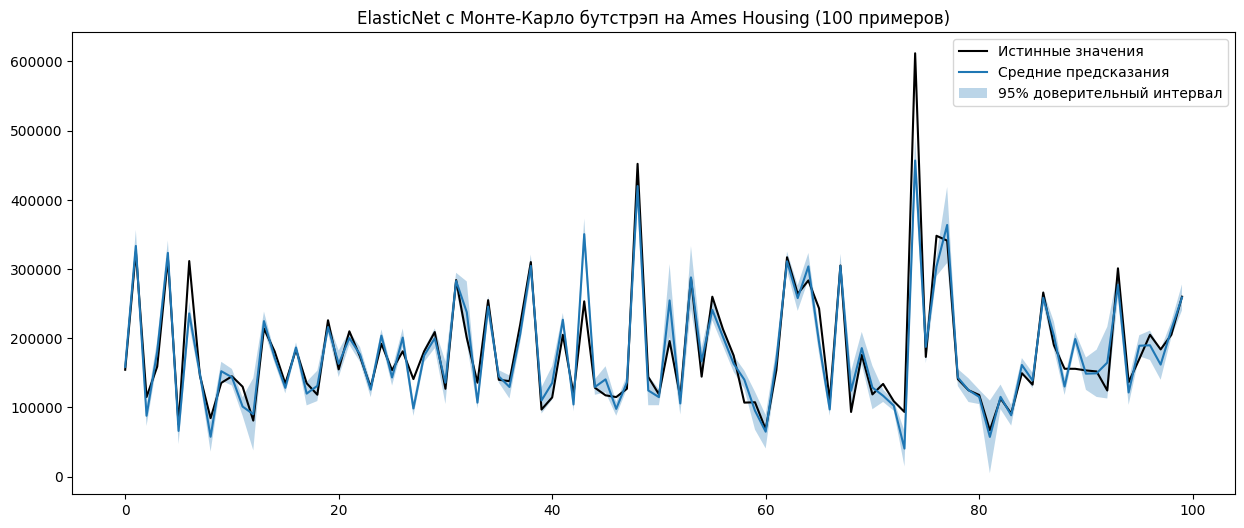

Обучаем и оцениваем XGBoost...
  Без МК: MSE=713142656.0000, R2=0.9070, MAE=17363.7324
  С МК бутстрэп: MSE=758048802.6604, R2=0.9012, MAE=16759.4571


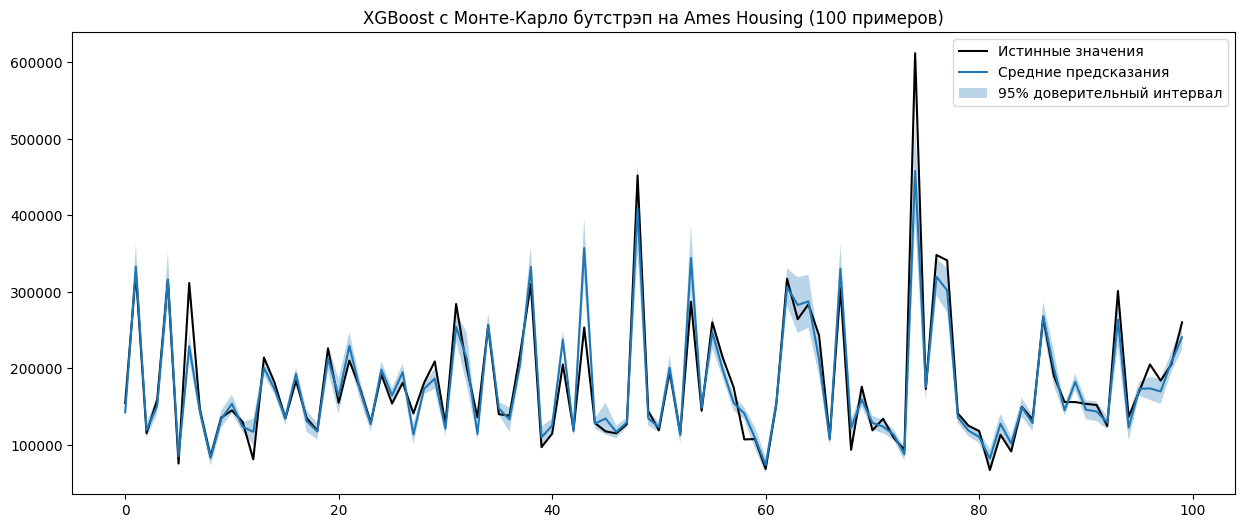

Обучаем и оцениваем CatBoost...
  Без МК: MSE=789392921.5450, R2=0.8971, MAE=17638.1556
  С МК бутстрэп: MSE=825543384.1959, R2=0.8924, MAE=17647.8041


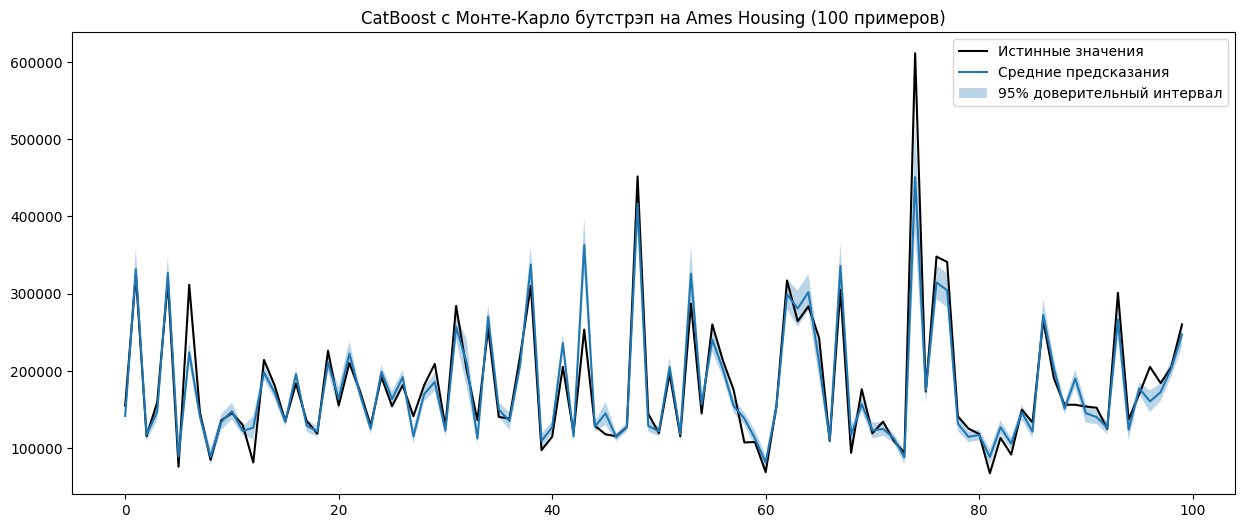

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openml

from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import xgboost as xgb
from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

# --- Загрузка и подготовка данных ---

def load_california():
    data = fetch_california_housing()
    X, y = data.data, data.target
    feature_names = data.feature_names
    return X, y, feature_names

def load_diabetes_data():
    data = load_diabetes()
    return data.data, data.target, data.feature_names


def load_ames():
    ames = openml.datasets.get_dataset(42165)
    X, y, _, _ = ames.get_data(target=ames.default_target_attribute, dataset_format='dataframe')
    numeric_cols = X.select_dtypes(include=['number']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
    X[categorical_cols] = X[categorical_cols].fillna('Missing')
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    return X.values, y.values, list(X.columns)

    
# --- Предобработка ---

def preprocess(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# --- Метрики ---

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, r2, mae

# --- Модели и методы Монте-Карло ---

models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_seed=42)
}

def monte_carlo_bootstrap(model, X_train, y_train, X_test, n_iter=50):
    preds = np.zeros((n_iter, len(X_test)))
    for i in range(n_iter):
        idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
        model.fit(X_train[idx], y_train[idx])
        preds[i] = model.predict(X_test)
    return preds

# --- Нейросеть с MC Dropout ---

class MLP_MC_Dropout(nn.Module):
    def __init__(self, input_dim, dropout_p=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def train_nn(model, train_loader, epochs=50, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

def mc_dropout_predict(model, X_test, n_iter=50):
    model.train() 
    preds = []
    with torch.no_grad():
        for _ in range(n_iter):
            preds.append(model(X_test).cpu().numpy())
    preds = np.array(preds).squeeze()
    return preds.mean(axis=0), preds.std(axis=0)

# --- Визуализация ---

def plot_predictions(y_true, preds_mean, preds_std, title):
    x_axis = np.arange(len(y_true))
    plt.figure(figsize=(15,6))
    plt.plot(x_axis, y_true, label='Истинные значения', color='black')
    plt.plot(x_axis, preds_mean, label='Средние предсказания')
    plt.fill_between(x_axis, preds_mean - 1.96*preds_std, preds_mean + 1.96*preds_std,
                     alpha=0.3, label='95% доверительный интервал')
    plt.title(title)
    plt.legend()
    plt.show()

# --- Основной эксперимент ---

def experiment(dataset_loader, dataset_name, use_nn=False):
    print(f"\n--- Эксперимент на {dataset_name} ---")
    X, y, feature_names = dataset_loader()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scaled, X_test_scaled = preprocess(X_train, X_test)

    results = {}

    for name, model in models.items():
        print(f"Обучаем и оцениваем {name}...")
        if name == 'Ridge':
            model = Ridge(alpha=1.0)
        elif name == 'Lasso':
            model = Lasso(alpha=0.1)
        elif name == 'ElasticNet':
            model = ElasticNet(alpha=0.1, l1_ratio=0.5)
        elif name == 'XGBoost':
            model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, n_estimators=100, learning_rate=0.1, random_state=42)
        elif name == 'CatBoost':
            model = CatBoostRegressor(depth=4, iterations=100, learning_rate=0.1, verbose=0, random_seed=42)
        else:
            continue

        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        mse, r2, mae = evaluate_metrics(y_test, preds)
        print(f"  Без МК: MSE={mse:.4f}, R2={r2:.4f}, MAE={mae:.4f}")

        mc_preds = monte_carlo_bootstrap(model, X_train_scaled, y_train, X_test_scaled, n_iter=50)
        mc_mean = mc_preds.mean(axis=0)
        mc_std = mc_preds.std(axis=0)
        mse_mc, r2_mc, mae_mc = evaluate_metrics(y_test, mc_mean)
        print(f"  С МК бутстрэп: MSE={mse_mc:.4f}, R2={r2_mc:.4f}, MAE={mae_mc:.4f}")

        results[name] = {
            'no_mc': (mse, r2, mae),
            'mc': (mse_mc, r2_mc, mae_mc),
            'mc_mean': mc_mean,
            'mc_std': mc_std
        }

        plot_predictions(y_test[:100], mc_mean[:100], mc_std[:100], f"{name} с Монте-Карло бутстрэп на {dataset_name} (100 примеров)")

    if use_nn:
        print("\nОбучаем MLP с MC Dropout...")
        input_dim = X_train_scaled.shape[1]
        model_nn = MLP_MC_Dropout(input_dim, dropout_p=0.2)
        X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32)
        train_ds = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

        train_nn(model_nn, train_loader, epochs=100, lr=0.001)

        X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)

        mean_preds, std_preds = mc_dropout_predict(model_nn, X_test_t, n_iter=50)

        mse_nn, r2_nn, mae_nn = evaluate_metrics(y_test, mean_preds)
        print(f"MLP MC Dropout: MSE={mse_nn:.4f}, R2={r2_nn:.4f}, MAE={mae_nn:.4f}")

        plot_predictions(y_test[:100], mean_preds[:100], std_preds[:100], f"MLP MC Dropout на {dataset_name} (100 примеров)")

        results['MLP_MC_Dropout'] = {
            'no_mc': None,
            'mc': (mse_nn, r2_nn, mae_nn),
            'mc_mean': mean_preds,
            'mc_std': std_preds
        }

    return results

# --- Запуск экспериментов ---

results_california = experiment(load_california, "California Housing", use_nn=True)
results_diabetes = experiment(load_diabetes_data, "Diabetes", use_nn=False)
results_ames = experiment(load_ames, "Ames Housing", use_nn=False)
